In [1]:
import glob
import os
import subprocess
import pickle as cPickle
import ast
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import numpy as np
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import seaborn as sns
import re

# Setup

In [2]:
#path depending on timebin
pca_res_path="./c-transfer"
pcmci_res_path="./output"
f1_scores_path="./output_f1-scores_lag1/time"
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL']


In [3]:
related_models=[] #wie am besten machen, falls überhaupt so? Hier mal als Äquivalenzklassen
related_models.append((0, 6, 10))
related_models.append((1,))
related_models.append((2,))
related_models.append((3,))
related_models.append((4,))
related_models.append((5,))
related_models.append((0, 6, 10))
related_models.append((7,))
related_models.append((8,))
related_models.append((9,))
related_models.append((0, 6, 10))

In [4]:
f1Scores={}
for file in os.listdir(f1_scores_path):
    match = re.search(r"time=([0-9.]+)", file)
    if match:
        time_value = float(match.group(1))
    else:
        print("no time found")
    f1_scores_single_path=os.path.join(f1_scores_path, file)
    f1_scores_single=pickle.load(open(f1_scores_single_path,"rb"))
    pc_alpha=f1_scores_single['pc_alpha']
    n_kept_comp=f1_scores_single['n_kept_comp']
    f1Scores[(pc_alpha, n_kept_comp, time_value)]=f1_scores_single['f1Scores']    

In [5]:
f1Scores_={} #f1Scores sortiert bzw. die einträge der keys sortiert nach alpha_value
for key in f1Scores:
    scores=f1Scores[key]
    tempList={}
    for element in scores:
        for key2 in element:
            tempList[key2]=element[key2]
    sorted_dict = dict(sorted(tempList.items()))
    f1Scores_[key]=sorted_dict
    

## Auswertung

In [6]:
avg_f1_scores_models={} #avg F1-Score for each refModel F1-Matrix
for key in f1Scores_:
    scores=f1Scores_[key]
    avg_f1_scores_models.setdefault(key, {})
    for key2 in scores:
        avg_f1_scores_models[key][key2]=np.nanmean(scores[key2], axis=(2, 3)) #also avg f1 score für key1=pc_alpha und key2=refDataSet

In [7]:
#metric1 for all refDatasets. Returns average f1-score-metric1-distance for all refDatasets
def metric1(f1scores): #f14d matrix
    result=[]
    for i,refDataset in enumerate(f1scores):
        scores=f1scores[i]
        min_scores=[]
        max_scores=[]
        for element in scores:
            arr=np.array(element)
            min_scores.append(np.nanmin(arr))
            max_scores.append(np.nanmax(arr))
        result.append(np.mean(np.subtract(max_scores, min_scores)))
    return result

In [8]:
def metric2_(key, f1scores, relModelsTuple, refModelIndex, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
    for i, modelIndex in enumerate(relModelsTuple):
        for j, model in enumerate(model_names):
            if j not in relModelsTuple:
                val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                avgF1Distance[i][j]=val
                                        
    return avgF1Distance, np.nanmean(avgF1Distance)
        
    
    

In [9]:
def metric2(key, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1DistanceFinal=[]
    for refModelIndex, model in enumerate(model_names):
        relModelsTuple=related_models[refModelIndex]
        avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
        for i, modelIndex in enumerate(relModelsTuple):
            for j, model in enumerate(model_names):
                if j not in relModelsTuple:
                    val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                    avgF1Distance[i][j]=val
        avgF1DistanceFinal.append(np.nanmean(avgF1Distance))
    #print(key, np.nanmean(np.array(avgF1DistanceFinal)))
    return np.array(avgF1DistanceFinal), np.nanmean(np.array(avgF1DistanceFinal))
        
    
    

In [10]:
def plot_metric2_div_metric1(key):
    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    
    for element in x_values:
        element=np.log10(element)
        
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0])
    plt.title(plotTitle)
    plt.ylabel('F1-Score')
    plt.figtext(0, 0, 'The resulting M2/M1 for N components, specific pc_alpha (see title) and different alpha_values vizualized')

    plt.ylim(0, 3)
    
    # Plot anzeigen
    plt.show()

In [11]:
metric1Mins={} #Mins for the metric1 mean values per (alphaValue, n_kept_comp)
for key in f1Scores_:
    metric1values=[]
    f1_score_single=f1Scores_[key] 
    for key2 in f1_score_single:
        metric1values.append(   (key2, np.mean((metric1(f1_score_single[key2]))))   )
        if key[1]==100 and key2==0.0005:
            metric1_vs_pcAlpha.append((key[0], np.mean((metric1(f1_score_single[key2])))))
    metric1Mins[key]=min(metric1values, key = lambda t: t[1])

        


In [12]:
metric2Maxs={}
for key in f1Scores_:
    metric2values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        #metric2values.append((key2, metric2_(key, None, related_models[0], 6, key2)[1]))
        metric2values.append((key2, metric2(key, key2)[1]))
        if key[1]==100 and key2==0.0005:
            metric2_vs_pcAlpha.append((key[0], metric2(key, key2)[1]))
    metric2Maxs[key]=max(metric2values, key = lambda t: t[1])

In [13]:
metric2_div_metric1_maxs={}
metric2_div_metric1={}
for key in f1Scores_:
    metric2divmetric1values=[]
    f1_score_single=f1Scores_[key]
    metric2_div_metric1.setdefault(key, [])
    for key2 in f1_score_single:
        m1=np.mean(metric1(f1_score_single[key2]))
        #m2=metric2_(key, None, related_models[0], 6, key2)[1]
        m2=metric2(key, key2)[1]
        metric2divmetric1values.append((key2, m2/m1, m2, m1))
        metric2_div_metric1[key].append((key2, m2/m1))
    metric2_div_metric1_maxs[key]=max(metric2divmetric1values, key = lambda t: t[1])

/tmp/ipykernel_2482/1632574356.py:11: RuntimeWarning: invalid value encountered in double_scalars
  metric2divmetric1values.append((key2, m2/m1, m2, m1))
/tmp/ipykernel_2482/1632574356.py:12: RuntimeWarning: invalid value encountered in double_scalars
  metric2_div_metric1[key].append((key2, m2/m1))


In [14]:
metric2_div_metric1_maxs_2={} #(comps, pc_alpha, alpha_value): F1-Score  wobei alpha_value für den max erreichten F1-Score gegeben ist
for key in metric2_div_metric1_maxs:
    pc_alpha=key[0]
    comps=key[1]
    time=key[2]
    alpha_value=metric2_div_metric1_maxs[key][0]
    metric2_div_metric1_maxs_2[(comps,pc_alpha,alpha_value,time)]=metric2_div_metric1_maxs[key]

In [15]:
sorted_dict_komps = dict(sorted(metric2_div_metric1_maxs_2.items(), key=lambda x: x[0][0])) #sortiert nach comps, dann pc_alpha

In [16]:
temp = sorted(sorted_dict_komps.items(), key=lambda x: x[1][1])

# Visualization

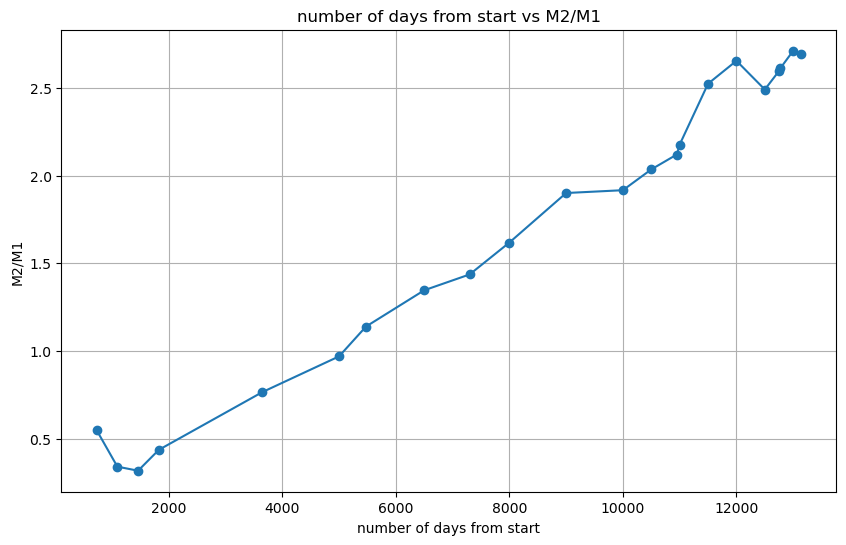

In [17]:
sorted_data = sorted(temp, key=lambda x: x[0][3])
x_values = [entry[0][3] for entry in sorted_data]
y_values = [entry[1][1] for entry in sorted_data]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('number of days from start')
plt.ylabel('M2/M1')
plt.grid(True)
plt.title('number of days from start vs M2/M1')
#plt.savefig('./BilderBA/timeanalysis_moreData_lag1_100comp_pcalpha-32.pdf')

plt.show()